In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessClassifier

In [75]:
df = pd.read_csv('./embeddings_combined.csv')

In [76]:
# Standardize the data before Using PCA to reduce dimensions
from sklearn.preprocessing import StandardScaler

embedding_cols = [str(i) for i in range(1024)]
scaler = StandardScaler()
df[embedding_cols] = scaler.fit_transform(df[embedding_cols].values)

In [77]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA

PCA_reducer = PCA(n_components=512)
pca_embeddings = PCA_reducer.fit_transform(df[embedding_cols])

In [78]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['sector_encoded'] = label_encoder.fit_transform(df['sector'])
num_classes = len(df['sector'].unique())

In [79]:
X = df[embedding_cols].values
# X = pca_embeddings
y = df['sector_encoded'].values

In [80]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Data split into training and test sets.")

print(len(X_test), len( X_train), len(y_test), len(y_train))

Data split into training and test sets.
7615 30457 7615 30457


In [81]:
# from sklearn.base import BaseEstimator, ClassifierMixin
# import numpy as np

# class CustomGDA(BaseEstimator, ClassifierMixin):
#     def __init__(self):
#         pass

#     def fit(self, X, y):
#         self.classes_ = np.unique(y)
#         n_classes = len(self.classes_)
#         n_features = X.shape[1]

#         self.phi_ = np.zeros(n_classes)
#         self.mu_ = np.zeros((n_classes, n_features))
#         self.sigma_ = np.zeros((n_features, n_features))

#         for i, cls in enumerate(self.classes_):
#             X_cls = X[y == cls]
#             self.phi_[i] = X_cls.shape[0] / X.shape[0]
#             self.mu_[i] = np.mean(X_cls, axis=0)

#         for cls in self.classes_:
#             X_cls = X[y == cls]
#             self.sigma_ += np.cov(X_cls, rowvar=False) * (X_cls.shape[0] - 1)

#         self.sigma_ /= (X.shape[0] - n_classes)
#         self.sigma_inv_ = np.linalg.inv(self.sigma_)
#         return self

#     def predict(self, X):
#         n_classes = len(self.classes_)
#         n_samples = X.shape[0]
#         probs = np.zeros((n_samples, n_classes))

#         for i in range(n_classes):
#             diff = X - self.mu_[i]
#             probs[:, i] = np.log(self.phi_[i]) - 0.5 * np.diag(diff @ self.sigma_inv_ @ diff.T)

#         return self.classes_[np.argmax(probs, axis=1)]
    
from sklearn.base import BaseEstimator, ClassifierMixin
from joblib import Parallel, delayed
import numpy as np

class CustomGDA(BaseEstimator, ClassifierMixin):
    def __init__(self, n_jobs=1):
        self.n_jobs = n_jobs  # Number of parallel jobs

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_features = X.shape[1]

        # Parallel computation of class-specific parameters
        results = Parallel(n_jobs=self.n_jobs)(delayed(self.compute_class_stats)(X, y, cls) for cls in self.classes_)

        # Unpack results
        self.mu_ = np.array([res[0] for res in results])
        self.phi_ = np.array([res[1] for res in results])

        # Average covariance matrix across all classes
        self.sigma_ = np.mean([res[2] for res in results], axis=0)

    def compute_class_stats(self, X, y, cls):
        X_cls = X[y == cls]
        mu = np.mean(X_cls, axis=0)
        phi = X_cls.shape[0] / X.shape[0]
        sigma = np.cov(X_cls, rowvar=False)  # Assumes full covariance matrix; modify if assuming diagonal covariance
        return mu, phi, sigma

    def predict(self, X):
        # Probabilities for each class, computed using the Gaussian distribution's properties
        # This part can also be parallelized if necessary
        probs = np.array([self.compute_probability(X, i) for i in range(len(self.classes_))]).T
        return self.classes_[np.argmax(probs, axis=1)]

    def compute_probability(self, X, idx):
        # Example probability computation, this should be adapted to your actual discriminative function
        mu = self.mu_[idx]
        sigma_inv = np.linalg.inv(self.sigma_)
        return -0.5 * np.sum((X - mu) @ sigma_inv * (X - mu), axis=1) + np.log(self.phi_[idx])



In [82]:

from sklearn.model_selection import cross_val_score

model = CustomGDA()


# Perform 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(f'Cross-validated accuracy scores: {scores}')
print(f'Mean accuracy: {scores.mean()}')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)





/Users/d.ark/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/d.ark/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/d.ark/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/d.ark/anaconda3/lib/python3.10/site-packages/numpy/cor

Cross-validated accuracy scores: [0.78555483 0.80525279 0.8048332  0.80601524 0.79353822]
Mean accuracy: 0.7990388545411993


/Users/d.ark/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


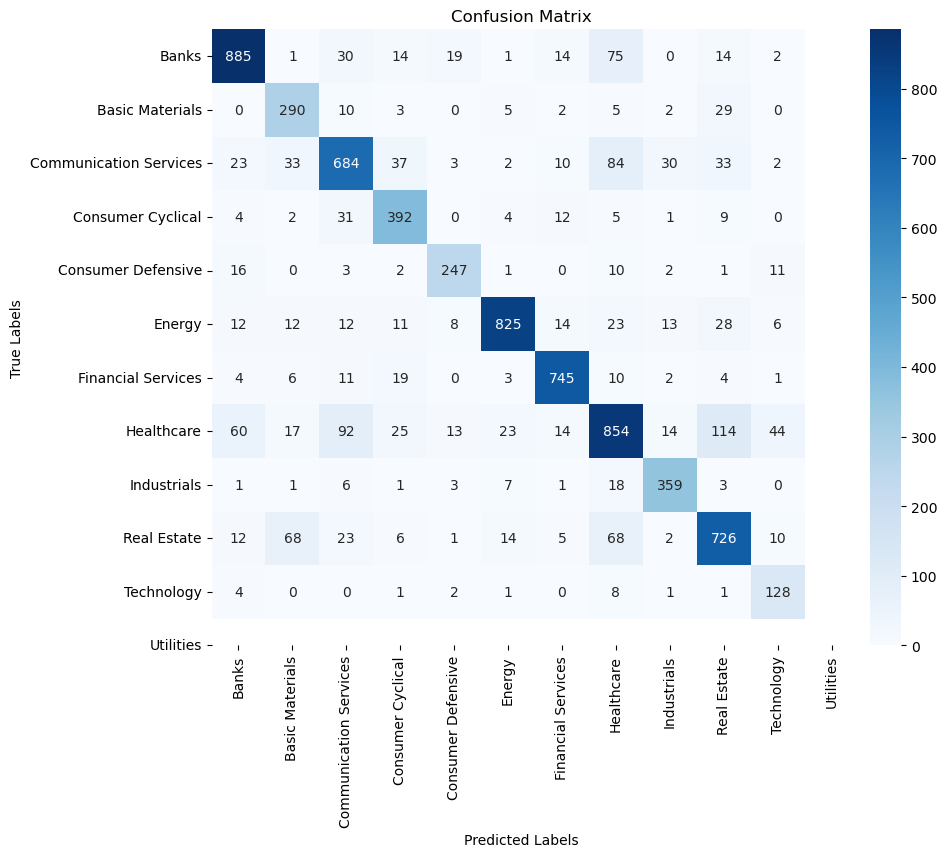

Accuracy: 0.8056
F1 Score: 0.8058


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")



In [84]:
from sklearn.preprocessing import LabelEncoder

label_encoder_industry = LabelEncoder()
df['industry_encoded'] = label_encoder_industry.fit_transform(df['industry'])
num_classes = len(df['industry'].unique())

In [85]:
#X_industry = df[embedding_cols].values
X_industry = df[embedding_cols].values

y_industry = df['industry_encoded'].values

In [86]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train_industry, X_test_industry, y_train_industry, y_test_industry = train_test_split(X_industry, y_industry, test_size = 0.2, random_state = 42)

print("Data split into training and test sets.")

print(len(X_test_industry), len( X_train_industry), len(y_test_industry), len(y_train_industry))

Data split into training and test sets.
7615 30457 7615 30457


In [92]:
from sklearn.model_selection import cross_val_score

model_industry = CustomGDA()


model_industry.fit(X_train_industry, y_train_industry)

y_pred_industry = model_industry.predict(X_test_industry)


/Users/d.ark/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Assuming label_encoder_industry was used to encode 'y'
classes = label_encoder_industry.classes_
unique_labels = np.unique(y_test_industry)  # Unique labels in y_test

# Get the target names for the unique labels only
target_names = [classes[label] for label in unique_labels]

# Calculate precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_industry, y_pred_industry, labels=unique_labels, average=None)

# Generate the classification report for the actual labels in y_test
report = classification_report(y_test_industry, y_pred_industry, labels=unique_labels, target_names=target_names)
print(report)


                                                precision    recall  f1-score   support

                          Advertising Agencies       0.54      0.72      0.62        61
                           Aerospace & Defense       0.74      0.74      0.74        53
                           Agricultural Inputs       0.78      0.74      0.76        39
                                      Airlines       0.69      1.00      0.82         9
                       Airports & Air Services       0.54      0.70      0.61        10
                                      Aluminum       0.75      0.86      0.80        14
                         Apparel Manufacturing       0.68      0.72      0.70        72
                                Apparel Retail       0.44      0.42      0.43        33
                          Application Software       0.00      0.00      0.00         1
                              Asset Management       0.88      0.72      0.79       207
                      Auto & Tr

/Users/d.ark/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/d.ark/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/d.ark/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/d.ark/anaconda3/lib/p

Limited Data for Some Classes: For the classes with very few examples, the data failed to split into training and testing set. I exclude them in my model and final comparing resurlts. This might be a reseaon for the comparatively high accuracy here. 

I have used ChatGPT to aid the python syntax 